### Notes

This notebook works as the research place to choose what features to extract from audio files. The features will be used to train the model in the main notebook.

### Load Audio Pieces

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import torchaudio

df_attributes = pd.read_csv('../dataset/stories_attributes.csv')

list_waveform = []
list_sample_rate = []
for i in tqdm(range(len(df_attributes))):
    wav_file = f'../dataset/stories/{df_attributes.iloc[i]["filename"]}'
    waveform, sample_rate = torchaudio.load(wav_file)
    list_waveform.append(waveform[0]) # only pick one channel
    list_sample_rate.append(sample_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

### Do Preprocessing (#1, Obsolete)

This preprocessing procedure will output bad features. See #2 for the correct one.

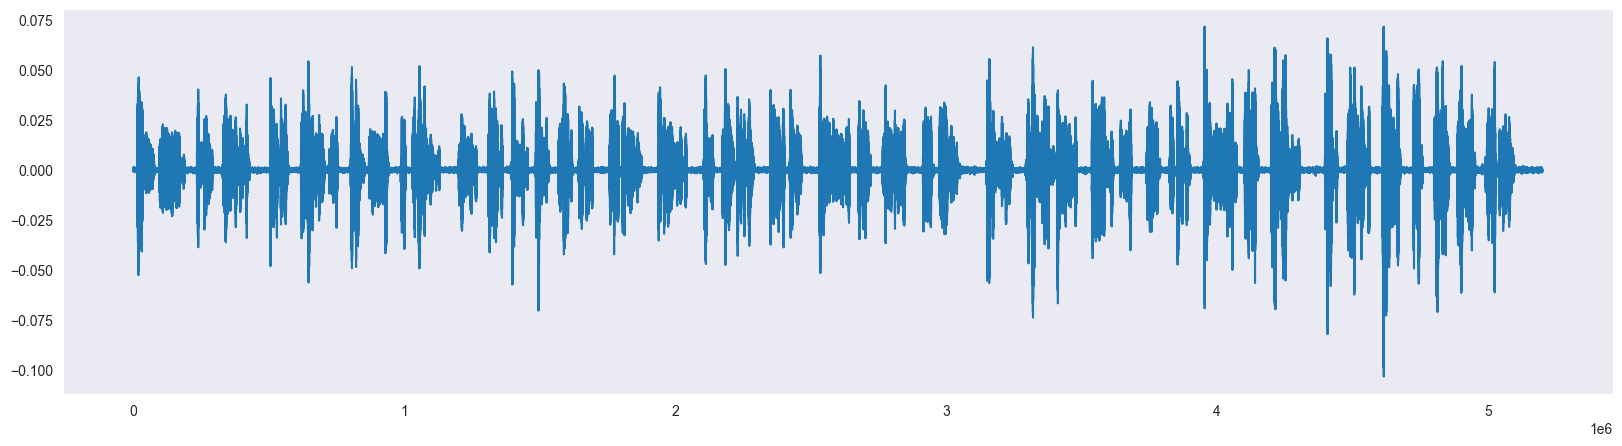

In [9]:
import matplotlib.pyplot as plt

wf = list_waveform[0]
sr = list_sample_rate[0]
plt.figure(figsize=(20, 5))
plt.plot(wf)
plt.grid()
plt.show()

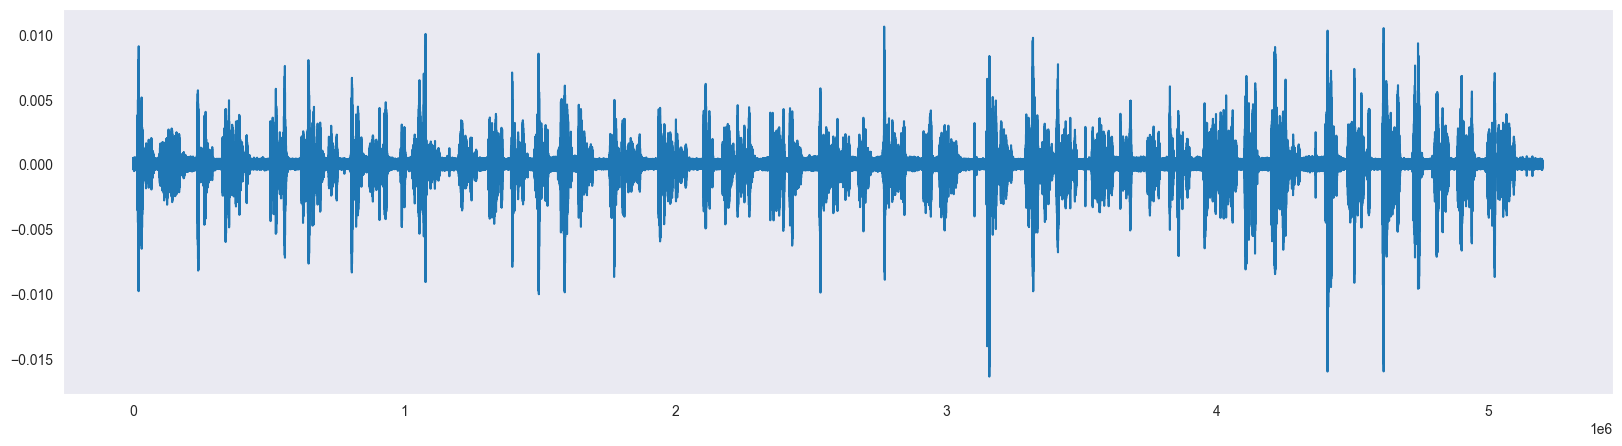

In [10]:
import numpy as np

# Do Pre-Emphasis
emphasized_wf = np.append(wf[0], wf[1:] - 0.97 * wf[:-1])
frame_size, frame_stride = 0.025, 0.01
frame_length, frame_step = int(round(frame_size * sr)), int(round(frame_stride * sr))
signal_length = len(emphasized_wf)
num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
plt.figure(figsize=(20, 5))
plt.plot(emphasized_wf)
plt.grid()
plt.show()

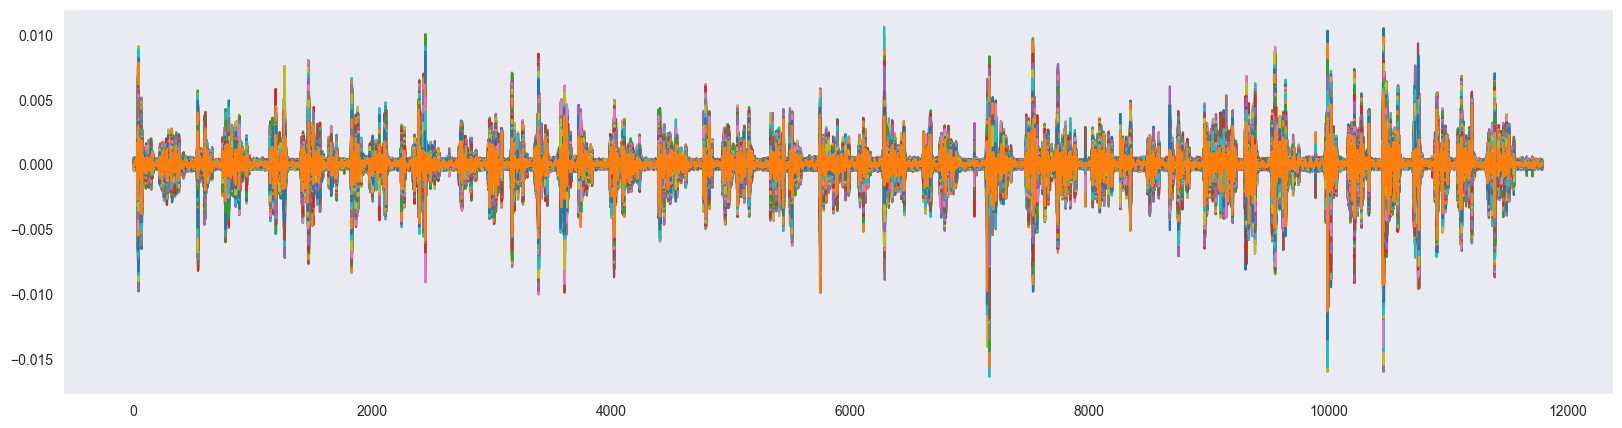

In [11]:
# Do Padding and Framing
pad_wf_length = (num_frames - 1) * frame_step + frame_length
z = np.zeros((pad_wf_length - signal_length))
pad_wf = np.append(emphasized_wf, z)
indices = np.arange(0, frame_length).reshape(1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
framed_wf = pad_wf[indices]
plt.figure(figsize=(20, 5))
plt.plot(framed_wf)
plt.grid()
plt.show()

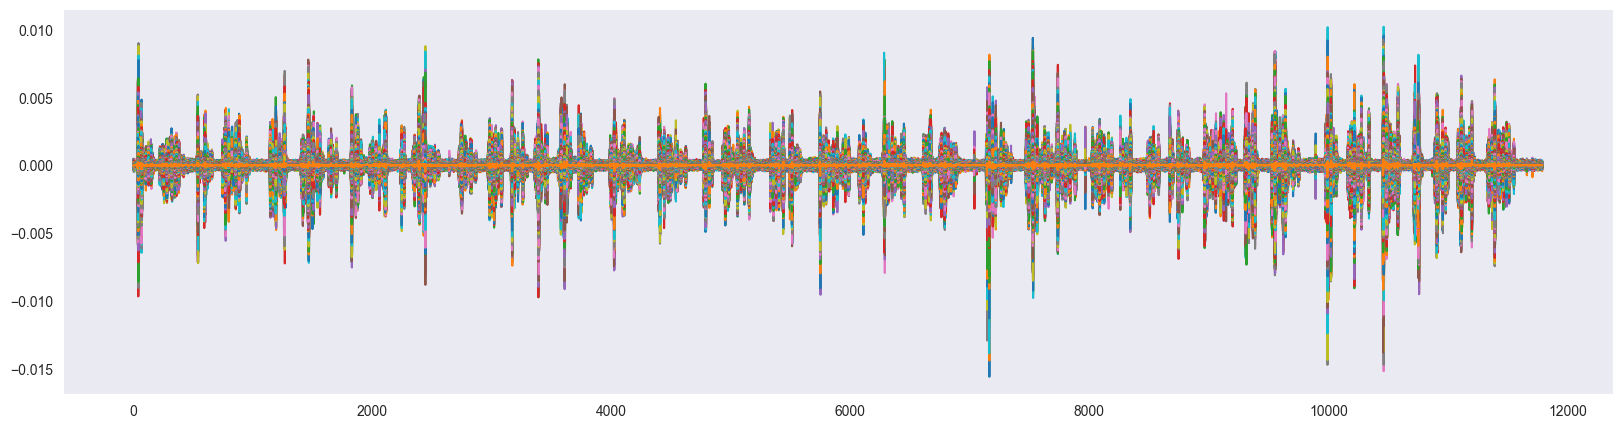

In [12]:
# Add Hamming Window
hamming = np.hamming(frame_length)
framed_wf *= hamming
plt.figure(figsize=(20, 5))
plt.plot(framed_wf)
plt.grid()
plt.show()

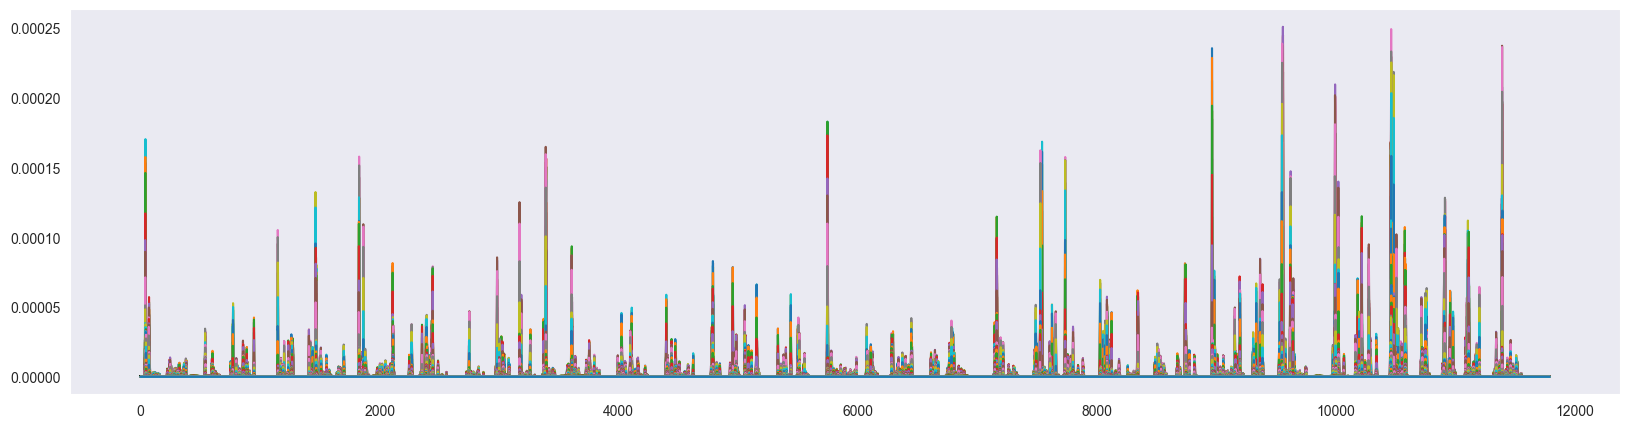

In [20]:
# Do Fourier Transform
NFFT = 5000
mag_frames = np.absolute(np.fft.rfft(framed_wf, NFFT))
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
plt.figure(figsize=(20, 5))
plt.plot(pow_frames)
plt.grid()
plt.show()

0 3923.337321740179


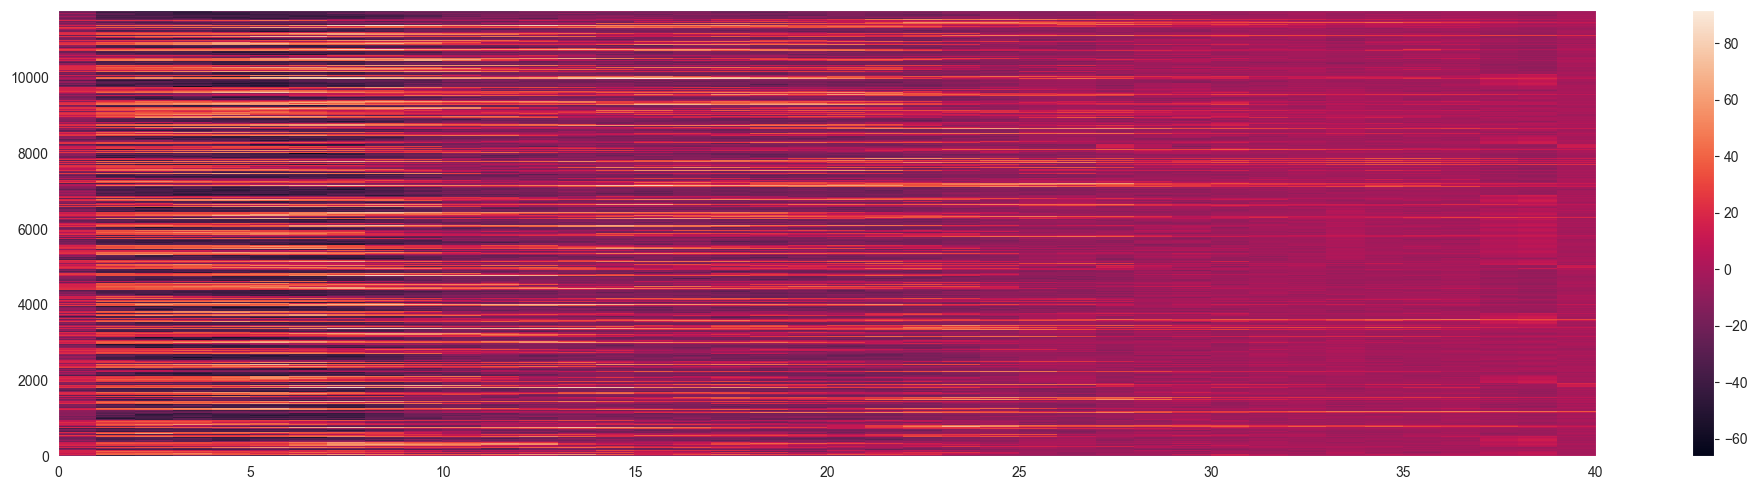

In [21]:
# Turn to Mel Format
low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sr / 2) / 700)
print(low_freq_mel, high_freq_mel)

n_filter = 40
mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filter + 2)
hz_points = 700 * (10 ** (mel_points / 2595) - 1)

# Get F Bank Features
f_bank = np.zeros((n_filter, int(NFFT / 2 + 1)))
bin_place = (hz_points / (sr / 2)) * (NFFT / 2)
for i in range(1, n_filter + 1):
    left = int(bin_place[i - 1])
    center = int(bin_place[i])
    right = int(bin_place[i + 1])
    for j in range(left, center):
        f_bank[i - 1, j + 1] = (j + 1 - bin_place[i - 1]) / (bin_place[i] - bin_place[i - 1])
    for j in range(center, right):
        f_bank[i - 1, j + 1] = (bin_place[i + 1] - (j + 1)) / (bin_place[i + 1] - bin_place[i])

filter_banks = np.dot(pow_frames, f_bank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks) # in dB format
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8) # mean normalization

fig = plt.figure(figsize=(20, 5))
heatmap = plt.pcolor(filter_banks)
fig.colorbar(mappable=heatmap)
plt.tight_layout()

In [22]:
print(filter_banks.shape, filter_banks)

(11791, 40) [[-19.04980079 -35.42574317 -37.82454097 ...   1.21842521   3.76440988
   -1.40596173]
 [-21.52762555 -29.06934819 -44.74022017 ...   3.36491067   5.47468514
   -0.21589763]
 [-11.76250941 -38.00998266 -49.18654815 ...   1.72183312   4.96943157
    0.22629901]
 ...
 [-22.37140718 -34.88333018 -28.69106558 ...  -3.7092771   -5.57983191
   -2.78251851]
 [ -8.36142992 -26.53908147 -28.59454577 ...  -5.56988158  -6.15332368
   -1.12137789]
 [-19.19086895 -35.55592061 -31.96631721 ...  -8.87373097  -7.78031031
   -2.4557064 ]]


### Librosa Comparison

After trial, we got that Preprocess #1 outputs wrong answers. We will redo the preprocessing.

In [4]:
import librosa.feature
import numpy as np

wf = list_waveform[0]
sr = list_sample_rate[0]

ls_f_bank = librosa.feature.melspectrogram(y=np.asarray(wf), sr=sr, n_mels=40, fmax=sr/2)
print(ls_f_bank.shape, ls_f_bank)

(40, 10157) [[2.2470849e-04 3.4680843e-04 3.1480810e-04 ... 4.1102507e-04
  6.4131920e-04 4.9368013e-04]
 [1.3869406e-05 1.3317994e-05 1.2780908e-05 ... 2.7801510e-05
  3.0636882e-05 2.5199994e-05]
 [6.2116105e-06 3.4365951e-06 2.1507524e-06 ... 7.4621339e-06
  1.3125544e-05 6.9620992e-06]
 ...
 [1.0122025e-07 2.0587206e-07 2.6391956e-07 ... 2.5224313e-07
  2.4791913e-07 1.6496429e-07]
 [4.6934406e-07 9.7654322e-07 1.1493706e-06 ... 3.2240303e-07
  2.8623171e-07 1.9799066e-07]
 [8.0861852e-08 1.7690833e-07 2.2215582e-07 ... 1.5758383e-07
  1.8821855e-07 1.6027087e-07]]


### Do Preprocessing (#2)

This preprocessing procedure will output correct features.

In [13]:
import torch
import math

wf = list_waveform[0]
sr = list_sample_rate[0]

# Do Pre-Emphasis
def pre_emphasis(signal, pre_emphasis_coeff=0.97):
    emphasized_signal = torch.cat((signal[:1], signal[1:] - pre_emphasis_coeff * signal[:-1]))
    return emphasized_signal

# Do Padding and Framing
def framing(signal, frame_size, frame_stride, sample_rate):
    frame_length = frame_size * sample_rate
    frame_step = frame_stride * sample_rate
    signal_length = signal.shape[0]
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(math.ceil(float(abs(signal_length - frame_length)) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    z = torch.zeros(pad_signal_length - signal_length)
    pad_signal = torch.cat((signal, z))

    indices = torch.arange(0, frame_length).unsqueeze(0) + torch.arange(0, num_frames * frame_step, frame_step).unsqueeze(1)
    frames = pad_signal[indices.long()]
    return frames

# Add Hamming Window
def windowing(frames):
    window = torch.hamming_window(frames.shape[1])
    windowed_frames = frames * window
    return windowed_frames

# Do Fourier Transform
def compute_fft(frames, NFFT):
    complex_spectrum = torch.fft.rfft(frames, n=NFFT)
    power_spectrum = (complex_spectrum.real ** 2 + complex_spectrum.imag ** 2)
    return power_spectrum

# Do Mel Filter Banks
def mel_filter_bank(sample_rate, NFFT, nfilt, low_freq=0, high_freq=None):
    if high_freq is None:
        high_freq = sample_rate / 2

    def hz_to_mel(hz):
        return 2595 * torch.log10(1 + hz / 700)

    def mel_to_hz(mel):
        return 700 * (10**(mel / 2595) - 1)

    mel_low = hz_to_mel(torch.tensor(low_freq))
    mel_high = hz_to_mel(torch.tensor(high_freq))
    mel_points = torch.linspace(mel_low, mel_high, nfilt + 2)
    hz_points = mel_to_hz(mel_points)
    bin = torch.floor((NFFT + 1) * hz_points / sample_rate).long()

    fbank = torch.zeros(nfilt, NFFT//2 +1)
    for m in range(1, nfilt +1):
        f_m_minus = bin[m -1]
        f_m = bin[m]
        f_m_plus = bin[m +1]

        for k in range(f_m_minus, f_m):
            fbank[m-1, k] = (k - bin[m-1]) / (bin[m] - bin[m-1] + 1e-8)
        for k in range(f_m, f_m_plus):
            fbank[m-1, k] = (bin[m +1] - k) / (bin[m +1] - bin[m] + 1e-8)
    return fbank

def apply_mel_filter(power_spectrum, fbank):
    mel_energies = torch.matmul(power_spectrum, fbank.t())
    mel_energies = torch.clamp(mel_energies, min=1e-10)
    return mel_energies

def f_bank_feature_extraction(wf, sample_rate=16000, pre_emphasis_coeff=0.97,
                             frame_size=0.025, frame_stride=0.01, NFFT=512, nfilt=40):
    emphasized_wf = pre_emphasis(wf, pre_emphasis_coeff)
    frames = framing(emphasized_wf, frame_size, frame_stride, sample_rate)
    windowed_frames = windowing(frames)
    power_spectrum = compute_fft(windowed_frames, NFFT)
    fbank = mel_filter_bank(sample_rate, NFFT, nfilt)
    mel_energies = apply_mel_filter(power_spectrum, fbank)
    log_mel_features = torch.log(mel_energies)
    return log_mel_features

f_bank_features = f_bank_feature_extraction(wf)
print(f_bank_features.shape, f_bank_features)

torch.Size([32500, 40]) tensor([[-13.5850, -14.6397, -15.6510,  ...,  -8.9503, -10.4548, -10.4798],
        [-12.8059, -15.3922, -15.6784,  ...,  -7.9244, -10.2012, -10.1235],
        [-13.1397, -14.7644, -15.6606,  ...,  -8.3250, -10.0944, -10.0233],
        ...,
        [-12.1530, -15.7591, -16.3126,  ...,  -9.8096, -10.1191,  -9.9050],
        [-13.3105, -15.8981, -15.7218,  ...,  -9.7364,  -9.2953,  -9.7993],
        [-14.1651, -14.4351, -15.1707,  ...,  -9.8548, -10.3334, -10.4512]])
